## A/B-тестирование

Задача — провести оценку результатов A/B-теста.

Для нас подготовлено техническое задание:

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
Так же в нашем распоряжении есть датасет с действиями пользователей и несколько вспомогательных датасетов:

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants` — таблица участников тестов.
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### План

1. [Открыть файлы и изучить общую информацию, выявить проблемы в данных](#start)
2. [Предобработка данных:](#preparing_data)
 - [Проверить типы данных, при необходимости привести к нужному типу;](#check_type)
 - [Проверить данные на наличие пропущенных значений и дубликатов](#check_empty_duplicate)
3. [Исследовательский анализ данных:](#research_analysis)
 - [Найти уникальные события и отсортировать их по частоте;](#unique_event)
 - [Посчитать, сколько пользователей совершали каждое из этих событий;](#unique_user_by_event)
 - [Посчитать по воронке событий , какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем), какая доля пользователей доходит от первого события до оплаты;](#funnel_share)
 - [Отфильтровать новых зарегистрированных пользователей по региону EU;](#EU_region)
 - [Отфильтровать данные по актуальному тесту recommender_system_test, проверить нет ли пересечения пользователей с другим тестом;](#intersection_test)
 - [Отфильтровать пользователей, которые зарегистрировались менее чем за 14 дней до окончания теста;](#14_days_min)
 - [Проверить выборки на пересечение с маркетинговыми кампаниями;](#marketing_intersection)
 - [Выяснить есть ли пересечение пользователей по двум тестируемым выборкам;](#intersection_test_group)
 - [Построить график распределения количества событий на пользователя по двум группам;](#distribution_event_by_user)
 - [Найти максимальную и минимальную дату. Определить как распределены события по дням;](#distribution_event_by_date)
 - [Построить диаграмму распределения(scatter plot) количества событий на пользователя и исследоваать данные на наличие аномалий](#scatter_plot)
4. [Оценка результатов A/B-тестирования:](#ab_test_results_analysis)
  - [Проверить корректность деление трафика теста. Проверить достаточное ли количество пользователей в тесте. Проверить является ли время(количество дней) проведения теста корректным. Проверить данные на нормальность распределения и аномалии](#check_correct_ab_test_settings)
 - [Посчитать число пользователей, совершивших самое популярное событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Рассчитать предыдушие шаги для всех других событий](#z_test)
5. [Сформулировать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования.](#conclusion)

<a id="start"></a>
### Шаг 1. Откройте файл с данными и изучите общую информацию

In [214]:
import pandas as pd
from scipy import stats as st
from IPython.core.display import HTML
import seaborn as sns
import numpy as np
import math as mth
import pylab as pl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.patches as mpatches

In [215]:
marketing_events = pd.read_csv('/Users/olgakolegova/Desktop/Final_project_practicum/AB_test/ab_project_marketing_events.csv')
final_ab_events = pd.read_csv('/Users/olgakolegova/Desktop/Final_project_practicum/AB_test/final_ab_events.csv')
new_users = pd.read_csv('/Users/olgakolegova/Desktop/Final_project_practicum/AB_test/final_ab_new_users.csv')
participants = pd.read_csv('/Users/olgakolegova/Desktop/Final_project_practicum/AB_test/final_ab_participants.csv')


<a id="check_type"></a>
Изучим типы данных:

In [216]:
data_list = {'marketing_events': marketing_events,
             'final_ab_events': final_ab_events,
             'new_users': new_users,
             'participants': participants}

for title, data in data_list.items():
    display(HTML('<h3>{}:</h3>'.format(title.replace('_', ' ').capitalize())))
    display(data.head())
    display(data.describe())
    display(data.info())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,St. Valentine's Day Giveaway,APAC,2020-06-25,2021-01-03
freq,1,4,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 528.0+ bytes


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,FDCFCC982E638862,2020-12-21,EU,Android
freq,1,6290,46270,27520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,5314AD65517ADDFA,A,interface_eu_test
freq,2,9655,11567


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.2+ KB


None

Загруженный датасет marketing_events состоит из 4 столбцов и 14 строк и содержит только тип данных object. Исходя из условия, что в столбцах start_dt и finish_dt содержится информация о начале и окончинии маркетинговых кампаний далее заменим тип данных в этих столбцах на datetime.
Датасет final_ab_events состоит из 4 столбцов и  440317 строк и содержит типы данных object и float. Так как по условию в столбце event_dt содержится информация о дате и времени события далее заменим тип данных на datetime.
Датасет new_users состоит из 4 столбцов и 61733 строки содержит типы данных object. В столбце first_date хранятся данные о дате регистрации пользователя, поэтому далее приведем их к типу данных datetime
Датасет participants состоит из 3 столбцов и 18268 строк и содержит типы данных object в столбцах с номером индификатора пользователя(user_id), группы теста (group) и названием теста(ab_test)

<a id="preparing_data"></a>
### Шаг 2. Предобработка данных

In [217]:
#replace dt to date in column name
for title, data in data_list.items():
    for column_name in data.columns:
        if '_dt' in column_name or '_date' in column_name:
            data[column_name] = pd.to_datetime(data[column_name])

<a id="check_empty_duplicate"></a>
Проверим данные на наличие дубликатов и пропусков:

In [218]:
for title, data in data_list.items():
    display(HTML('<h3>{}:</h3>'.format(title.replace('_', ' ').capitalize())))
    print(data.isna().sum())

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


user_id       0
first_date    0
region        0
device        0
dtype: int64


user_id    0
group      0
ab_test    0
dtype: int64


In [219]:
# check that we only have na in details when it's not purchase event
final_ab_events[final_ab_events.event_name != 'purchase'].details.unique()

array([nan])

In [220]:
final_ab_events[final_ab_events.event_name == 'purchase'].isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

In [221]:
for title, data in data_list.items():
    display(HTML('<h3>{}:</h3>'.format(title.replace('_', ' ').capitalize())))
    print(data.duplicated().sum())

0


0


0


0


В датасете final_ab_events обнаружены пропущенные значения в столбце details, мы предположили, что пропуски содержатся во всех событиях кроме purchase, так как в нем отражены значения по продажам. Далее мы проверили нашу гипотезу, выбрав все событиях кроме purchase и проверив по ним уникальные значения по столбцу details. Так же мы проверили, что в столбце details по событию purchase нет пропущенных значений методом isna().sum()

<a id="research_analysis"></a>
### Шаг 3. Проведите исследовательский анализ данных:

<a id="unique_event"></a>
Выясним количество уникальных событий по каждому событию:

In [222]:
final_ab_events.event_name.value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

По воронке событий мы видим, что стартовое событие для пользователей это регистрация (login), далее идет просмотр продуктовых страниц, покупка и переход в корзину. Интересно заметить, что количество событий purchase и product_cart приблизительно равны, мы можем предположить, что событие purchase возможно совершить на сайте не переходя в корзину товаров(product_cart)

<a id="unique_user_by_event"></a>
Вычислим количество уникальных пользователей по воронке событий:

In [223]:
event_funnel_by_user = final_ab_events.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
event_funnel_by_user

,user_id
event_name,
login,58697
product_page,38929
purchase,19569
product_cart,19284


<a id="funnel_share"></a>
Так же вычислим, какая доля пользователей доходит до каждого шага воронки (от числа пользователей на предыдущем), и какая доля пользователей доходит от первого события до оплаты:

In [224]:
total_user = final_ab_events.user_id.nunique()
event_funnel_by_user['percentage'] = event_funnel_by_user.user_id / total_user
event_funnel_by_user['percent_from_previous'] = event_funnel_by_user.user_id / event_funnel_by_user.user_id.shift(1)
event_funnel_by_user

,user_id,percentage,percent_from_previous
event_name,,,
login,58697,0.999898,NaN
product_page,38929,0.663152,0.663220
purchase,19569,0.333356,0.502684
product_cart,19284,0.328501,0.985436


66% пользователей дошли до просмотра продуктовых страниц, из них 33% совершили покупку и 32% зашли в корзину, следовательно, мы можем предположить, что пользователи совершают заказы напрямую после просмотра продуктовых страниц не пользуясь корзиной

Смерджим таблицы зарегистрированных пользователей и участников теста, чтобы получить таблицу с данными по пользователям - дате регистрации, региону, типу устройства, группе теста:

In [225]:
participants = new_users.merge(participants, left_on='user_id', right_on='user_id', how='inner')
participants

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
4,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test
5,5BE017E9C8CC42F8,2020-12-07,EU,Android,B,interface_eu_test
6,96F27A054B191457,2020-12-07,EU,iPhone,B,interface_eu_test
7,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
8,DD4352CDCF8C3D57,2020-12-07,EU,Android,A,interface_eu_test
9,E6AF85675078215D,2020-12-07,EU,Android,A,interface_eu_test


<a id="EU_region"></a>
Выясним как распределены доли пользователей по регионам:

In [226]:
share_new_users = participants.groupby('region').agg({'user_id': 'nunique'})
share_new_users['share'] = share_new_users.user_id / participants.user_id.nunique()
display(share_new_users)

,user_id,share
region,,
APAC,72,0.004320
CIS,55,0.003300
EU,16316,0.978999
N.America,223,0.013381


Большинство пользователей из Европы (98%)

Отфильтруем и оставим только пользователей с регионом EU, как указано в техническом задание:

In [227]:
participants = participants[participants.region == 'EU']

Подсчитаем, сколько осталось уникальных пользователей после фильтрации:

In [228]:
participants.user_id.nunique()

16316

Выясним, сколько в нашем датасете тестов:

In [229]:
#participants data exclude 
participants.ab_test.value_counts()

interface_eu_test          11567
recommender_system_test     6351
Name: ab_test, dtype: int64

<a id="intersection_test"></a>
Отфильтруем и оставим данные только по тесту recommender_system_test, проверим пересечение аудитории по тестам и исключим пользователей, которые находятся в обоих тестах:

In [230]:
participants_recommender = participants[participants.ab_test == 'recommender_system_test']
participants_interface = participants[participants.ab_test == 'interface_eu_test']
common_users = set(participants_recommender.user_id.to_list()).intersection(set(participants_interface.user_id.to_list()))
participants = participants_recommender[~participants_recommender['user_id'].isin(common_users)]
participants.user_id.nunique()

4749

Объединим таблицу действий новых пользователей в период с 7 декабря 2020 по 4 января 2021 года с таблицей участников тестов:

In [231]:
#add event
participants = final_ab_events.merge(participants, left_on='user_id', right_on='user_id', how='right')

In [232]:
participants.reset_index().isna().sum()

index             0
user_id           0
event_dt       2155
event_name     2155
details       17333
first_date        0
region            0
device            0
group             0
ab_test           0
dtype: int64

После объединения таблицы по событиям с таблицей участников мы видим пропуски в столбцах event_dt,event_name,details так как не все пользователи, участвующие в тесте, совершали события 

In [233]:
participants = participants[~participants.event_name.isna()]

Вычислим дату, когда было последнее событие:

In [234]:
participants.event_dt.max() #actual test data finished on 30.

Timestamp('2020-12-30 06:42:52')

<a id="14_days_min"></a>
Отфильтруем и оставим только актуальный период (до 15 декабря), так как по условию сравнить метрики необходимо за 14 дней с момента регистрации пользователя:

In [235]:
participants = participants[participants.first_date < '2020-12-16']

In [236]:
participants['days_from_registration']= participants.event_dt - participants.first_date
participants.head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,days_from_registration
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:29
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:30
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,1 days 10:52:27
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17


Выведем воронку событий по пользователям по очищенным данным:

In [237]:
participants_user = participants.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
participants_user


,user_id
event_name,
login,1221
product_page,744
product_cart,358
purchase,341


In [238]:
total_user = participants.user_id.nunique()
participants_user['percentage'] = participants_user.user_id / total_user
participants_user['percent_from_previous'] = participants_user.user_id / participants_user.user_id.shift(1)
participants_user

,user_id,percentage,percent_from_previous
event_name,,,
login,1221,1.000000,NaN
product_page,744,0.609337,0.609337
product_cart,358,0.293202,0.481183
purchase,341,0.279279,0.952514


Распределим данные по тестовым группамм A и B:

In [239]:
participants_A = participants[participants.group == 'A']
participants_B = participants[participants.group == 'B']

<a id="intersection_test_group"></a>
Проверим, есть ли пересечение пользователей в группах:

In [240]:
# check if there is user in both group
common_users = set(participants[participants.group == 'A'].user_id.to_list()).intersection(set(participants[participants.group == 'B'].user_id.to_list()))
len(common_users) / participants.user_id.nunique()

0.0

Вычислим разницу распределения трафика по типу устройств по тестовым группам:

In [241]:
share_device_A = participants_A.groupby('device').agg({'user_id': 'nunique'})
share_device_A['share'] = share_device_A.user_id / participants_A.user_id.nunique()
share_device_B = participants_B.groupby('device').agg({'user_id': 'nunique'})
share_device_B['share'] = share_device_B.user_id / participants_B.user_id.nunique()
display(abs(share_device_A.share - share_device_B.share))

device
Android    0.020673
Mac        0.000993
PC         0.032547
iPhone     0.012867
Name: share, dtype: float64

Разницы между выборками около 3% по PC и менее 1% на Mac, 1-2% по мобильным устройствам

In [242]:
groupA_event = participants_A.groupby(['user_id','group']).agg({'event_name':'count'}).reset_index()
groupB_event = participants_B.groupby(['user_id','group']).agg({'event_name':'count'}).reset_index()
participants_A

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,days_from_registration
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:29
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:30
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,1 days 10:52:27
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17
5,831887FE7F2D6CBA,2020-12-07 06:50:29,login,NaN,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:29
6,831887FE7F2D6CBA,2020-12-08 10:52:26,login,NaN,2020-12-07,EU,Android,A,recommender_system_test,1 days 10:52:26
7,831887FE7F2D6CBA,2020-12-09 02:19:17,login,NaN,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17
8,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,EU,PC,A,recommender_system_test,0 days 19:42:40
9,3C5DD0288AC4FE23,2020-12-07 19:42:40,product_page,NaN,2020-12-07,EU,PC,A,recommender_system_test,0 days 19:42:40


In [243]:
print(groupA_event.user_id.nunique())
print(groupB_event.user_id.nunique())

844
377


Доля пользователей группы B приблизительно 3 к 1 группы A, что не является корректным делением трафика и может исказить финальные данные  A/B теста 

<a id="distribution_event_by_user"></a>
Построим диаграмму распределения количества событий по группам A и B:

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Распределение количества событий на пользователя по группам A и B')

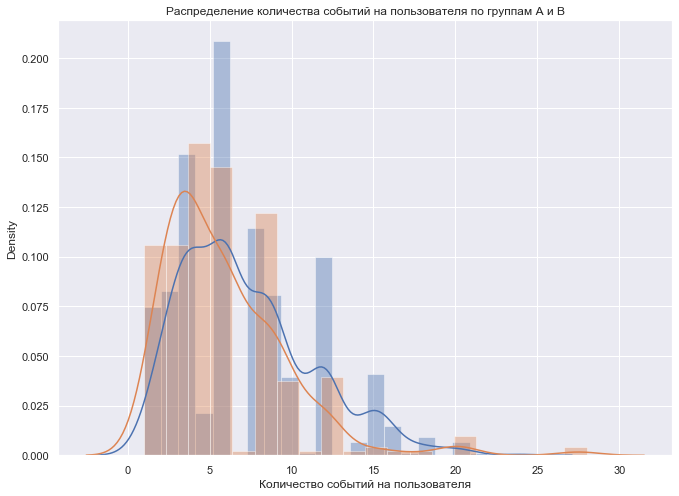

In [244]:
sns.set(rc={'figure.figsize':(11,8)})
sns.distplot(groupA_event.event_name, label='A')
sns.distplot(groupB_event.event_name, label='B')
plt.xlabel("Количество событий на пользователя")
plt.title("Распределение количества событий на пользователя по группам A и B")



Выведем дату из столбца event_dt с датой и временем:

In [245]:
participants['event_date'] = participants.event_dt.dt.date

<a id="distribution_event_by_date"></a>
Выведем на графике распределение событий по дням ,а так же отобразим на графике период проведения маркетинговых кампаний, которые совпали с проведением A/B теста:

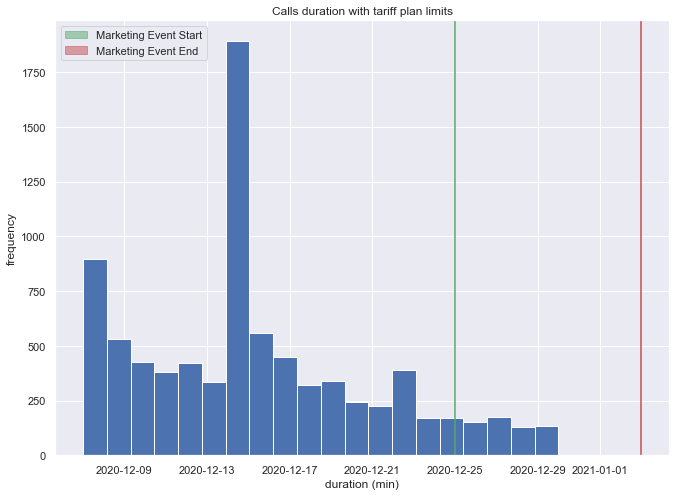

In [246]:
ax = plt.gca()
actual_marketing_events = marketing_events[(marketing_events.start_dt > '2020-12-06') & (marketing_events.finish_dt < '2021-01-05')]
start_events = actual_marketing_events.start_dt.to_list()
finish_events = actual_marketing_events.finish_dt.to_list()
for x in start_events:
    ax.axvline(x=x, color='g', linestyle='-')
for x in finish_events:
    ax.axvline(x=x, color='r', linestyle='-')
pl.title("Calls duration with tariff plan limits")
pl.xlabel("duration (min)")
pl.ylabel("frequency")
start_patch = mpatches.Patch(color='g', alpha=0.5, label='Marketing Event Start')
end_patch = mpatches.Patch(color='r', alpha=0.5, label='Marketing Event End')
plt.legend(handles=[start_patch, end_patch])
participants.event_date.hist(bins = 20)

Можно заметить, что период маркетинговой активности совпал с датами теста с 25.12, однако мы не наблюдаем аномального скачка в данных в этот период

<a id="scatter_plot"></a>
Построим график распределения событий на пользователей и выясним, есть ли у нас аномальные значения

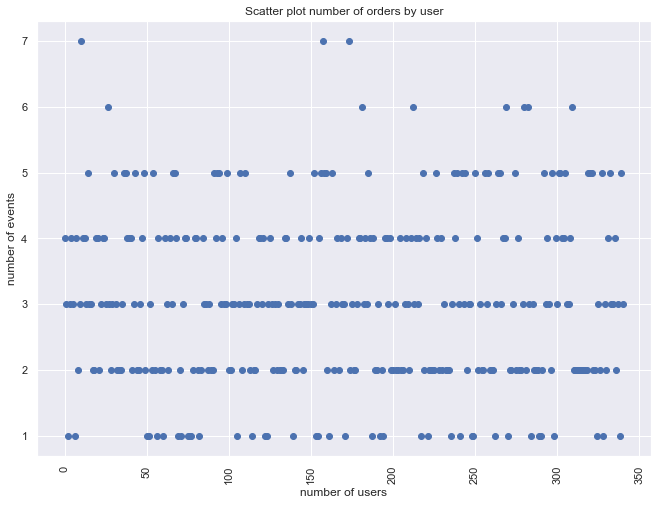

In [247]:
pl.title("Scatter plot number of orders by user")
pl.ylabel("number of events")
pl.xlabel("number of users")
plt.xticks(rotation=90)
events_by_users = participants[participants.event_name == 'purchase'].groupby('user_id')['event_name'].count()
events_by_users
x_value = range(0, len(events_by_users))
plt.scatter(x_value, events_by_users)

По графику распределения мы можем сделать вывод, что аномальные значения не присутствуют в выборках

Переведем данные по столбцам event_date и days_from_registration в формат даты:

In [248]:
participants.days_from_registration = participants.days_from_registration.dt.days

In [249]:
participants_A['event_date'] = participants_A.event_dt.dt.date
participants_A

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,days_from_registration,event_date
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:29,2020-12-07
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17,2020-12-09
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:30,2020-12-07
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,1 days 10:52:27,2020-12-08
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17,2020-12-09
5,831887FE7F2D6CBA,2020-12-07 06:50:29,login,NaN,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:29,2020-12-07
6,831887FE7F2D6CBA,2020-12-08 10:52:26,login,NaN,2020-12-07,EU,Android,A,recommender_system_test,1 days 10:52:26,2020-12-08
7,831887FE7F2D6CBA,2020-12-09 02:19:17,login,NaN,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17,2020-12-09
8,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,EU,PC,A,recommender_system_test,0 days 19:42:40,2020-12-07
9,3C5DD0288AC4FE23,2020-12-07 19:42:40,product_page,NaN,2020-12-07,EU,PC,A,recommender_system_test,0 days 19:42:40,2020-12-07


In [250]:
participants_B['event_date'] = participants_B.event_dt.dt.date


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<a id="ab_test_results_analysis"></a>
### Шаг 4. Оценка результатов A/B-тестирования:

<a id="check_correct_ab_test_settings"></a>
Напишем функцию, которая будет проверять данные на нормальность распределения:

In [251]:
def test_shapiro(sample):
    alpha = .05 # критический уровень статистической значимости

    results = st.shapiro(sample)
    p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: распределение не нормально")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, всё нормально") 

Применим функцию к нашим группам:

Нулевая гипотеза: Данные по событиям группы A нормально распределены

Альтернативная гипотеза H₁: Данные по событиям группы A ненормально распределены

In [253]:
test_shapiro(participants_A.groupby('event_date').event_name.count())

p-значение:  6.173440488055348e-05
Отвергаем нулевую гипотезу: распределение не нормально


Нулевая гипотеза: Данные по событиям группы B нормально распределены

Альтернативная гипотеза H₁: Данные по событиям группы B ненормально распределены

In [254]:
test_shapiro(participants_B.groupby('event_date').event_name.count())

p-значение:  0.003653799882158637
Отвергаем нулевую гипотезу: распределение не нормально


Распределение по двум группам ненормально, следовательно в данных могут быть выбросы

#### Расчёт размера выборки и длительности теста

Рассчитаем сколько в среднем пользователей заходили на сайт в день:

In [256]:
new_users.groupby('first_date').agg({'user_id':'nunique'}).mean()

user_id    3631.352941
dtype: float64

Определим минимальный размер выборки для определения относительного различия между группами теста в 10%, при базовой конверсии 28%, мощности теста в 80% и уровне значимости в 5%.
https://www.evanmiller.org/ab-testing/sample-size.html
- Baseline conversion rate: 28
- Minimum Detectable Effect: 10
- Sample size: 4,071

Рассчитаем минимальную длительность теста для определения относительного различия между группами теста в 10% при условиях: базовая конверсия 28%, групп (вариаций) 4, пользователей в день в среднем 50 000, из них в тесте участвует каждый второй.
https://vwo.com/tools/ab-test-duration-calculator/
- Estimated existing conversion rate (%) 28
- Minimum improvement in conversion rate you want to detect (%) 10
- Number of variations/combinations (including control) 2
- Average number of daily visitors 3631
- Percent visitors included in test 15
- Total number of days to run the test: 15 days

In [257]:
print('Уникальное количество пользователей группы A {} '.format(participants_A.user_id.nunique()))
print('Уникальное количество пользователей группы B {} '.format(participants_B.user_id.nunique()))

Уникальное количество пользователей группы A 844 
Уникальное количество пользователей группы B 377 


Проверка данных теста на корректность показала, что мы имеем недостаточное количество пользователей для рассчета требуемых метрик и минимально необходимо 15  дней для проведения теста. Кроме того размер наших групп неравномерен

<a id="z_test"></a>
Напишем функцию, с помощью которой будем рассчитывать долю пользователей совершивших каждое событие по всем событиям воронки и проверять наличие статистической разницы между группами. Для сравнения доли пользователей совершивших событие от общего количества пользователей по группам будем использовать z тест. В качестве альфы примем общепринятое пороговое значение — 5%. В качестве ожидаемого показателя улучшение конверсии добавим параметр expected_increase

In [258]:
def calculate_statistical_difference(event_name, group1, group2, expected_increase):
    key_event_users_1 = group1[group1.event_name == event_name]
    key_event_users_2 = group2[group2.event_name == event_name]
    key_metric_user_count_1 = key_event_users_1.user_id.nunique()
    key_metric_user_count_2 = key_event_users_2.user_id.nunique()
    key_metric_user_count_2 = key_metric_user_count_2 * (1 + expected_increase)
    total_users_1 = group1.user_id.nunique()
    total_users_2 = group2.user_id.nunique()
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([key_metric_user_count_1, key_metric_user_count_2])
    trials = np.array([total_users_1, total_users_2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    
    distr = st.norm(0, 1) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")


Проверим гипотезу по каждому уникальному событию: product_page, product_cart, purchase - о том, что доля пользователей, совершивших событие (от всех пользователей) по группе A, равна доле пользователей совершивших аналогичное событие по контрольной группе B.

Нулевая гипотеза: Доля пользователей, совершивших событие в группе A, не отличается от доли пользователей совершивших аналогичное событие в группе B (нет статистической значимой разницы).

Альтернативная гипотеза H₁: Доля пользователей, cовершивших событие в группе A, отличается от доли пользователей совершивших аналогичное событие в группе B (есть статистически значимая разница)

In [259]:
calculate_statistical_difference('product_page', participants_A, participants_B, 0.1)
calculate_statistical_difference('product_cart', participants_A, participants_B, 0.1)
calculate_statistical_difference('purchase', participants_A, participants_B, 0.1)


p-значение:  0.10430849805898412
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2257089972180324
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4194613169637007
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Исходя из данных, мы можем сделать вывод, что с учетом добавленного ожидаемого значения (улучшение каждой метрики не менее, чем на 10%) данные не противоречат нулевой гипотезе, следовательно мы можем считать доли равными, но если мы исключим ожидаемое значение, то метрики группы B будут ниже, следовательно ожидаемого эффекта прироста конверсии в 10% мы не получили. 

<a id="conclusion"></a>
### Вывод

Перед нами стояла задача оценить и проанализировать результаты A/B теста.

На первом этапе мы загрузили необходимые датасеты и проверили типы и разброс данных методами info() и describe().  Далее мы проверили данные на наличие пропусков и дубликатов и выяснили, что в таблице по событиям в столбце details содержатся пропущенные значения, но данный факт обусловлен тем, что по событию purchase у нас есть информация о стоимости покупки, которая хранится в столбце details, по остальным событиям, находящимся выше по воронке у нас уточняющей информации нет, поэтому мы оставили столбец details без изменений.

На следующем этапе мы провели исследовательский анализ и выяснили количество уникальных событий, уникальных пользователей по каждому событию, процент пользователей, дошедших до конца событийной воронки. Все эти данные помогли нам выяснить, что около 32% пользователей дошли до покупки, так же мы выяснили, что некоторые пользователи совершают покупки напрямую, после посещения продуктовых страниц, не заходя в продуктовую корзину. Далее, исходя из условия технического задания, мы оставили пользователей по региону Европа, отфильтровали пользователей, которые не участвовали в нашем тесте, проверили целевых пользователей на момент паралельного участия в других тестах и удалили пользователей, которые зарегистрировались менее чем за 14 дней до окончания теста. Далее по очищенным данным мы разделили пользователей на группы и проверили пересечение пользователей по ним. Так же мы проверили долю трафика по типам устройств в обеих группах. Одним из требований ТЗ было проверить пересечение теста с маркетинговыми активностями, поэтому мы построили график распределения количества событий по дням и дополнительно вывели период маркетинговых активностей, чтобы изучить пересечение в данных. В заключение на этом этапе мы исключили наличие аномалий в данных, построив диаграмму распределения по количеству событий на пользователя.

Последний этап состоял из анализа корректности проведения A/B теста и результатов. Проверив данные на нормальность методом st.shapiro(), мы пришли к выводу, что данные распределены ненормально. Далее, чтобы исключить основные ошибки при анализе результатов, мы подсчитали соотношение пользователей по двум группам и пришли к выводу, что они не корректно поделены (1:3). Также мы посчитали необходимый размер выборки в онлайн-калькуляторе, который был необходим по требуемым условиям теста (улучшение каждой метрики не менее, чем на 10%), анализ показал, что пользователей в наших выборках недостаточно. Поэтому, получив результаты z теста по нашим гипотезам о статистических равенствах в долях по целевым событиям воронки, мы не можем объективно утверждать, что результаты по группе B не показали увеличения целевых метрик на 10%, так как в тесте присутствуют критические ошибки.
